# Лабораторная работа 2 — Сегментация футболки

**Выполнил:** *Лунев Александр Вячеславович*  
**Группа:** *СП1*  

В этом ноутбуке решаем задачу сегментации области футболки по данным, подготовленным на первом этапе.

## План

1. Подготовка датасета и предварительный анализ.
2. Обучение полносвязной модели для сегментации.
3. Обучение сверточной модели (UNet).
4. Оценка качества и сравнение результатов.

In [1]:
# Установка зависимостей (при необходимости)
# !pip install torch torchvision pillow matplotlib numpy

In [12]:
import os
import sys
from pathlib import Path
from random import Random
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


## Подготовка данных

In [13]:
ROOT_DIR = Path.cwd()
LAB1_DIR = (ROOT_DIR.parent / "ImageProcessing_Lab1").resolve()
DATA_DIR = Path("dataset_tshirt")
IMAGES_DIR = DATA_DIR / "images"
MASKS_DIR = DATA_DIR / "masks"
RAW_IMAGE = (LAB1_DIR / "Nekit.jpg").resolve()

if str(LAB1_DIR) not in sys.path:
    sys.path.append(str(LAB1_DIR))

if not IMAGES_DIR.exists() or not list(IMAGES_DIR.glob('*.png')):
    print("Генерируем датасет футболки через модуль первой лабораторной...")
    from tshirt_dataset import (
        default_augmentations,
        generate_tshirt_samples,
        grabcut_person_mask,
        save_samples,
    )
    import cv2

    bgr = cv2.imread(str(RAW_IMAGE))
    if bgr is None:
        raise FileNotFoundError(f"Не найдено исходное изображение: {RAW_IMAGE}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    person_mask = grabcut_person_mask(rgb)

    base_aug = default_augmentations()
    extra_aug = {
        **base_aug,
        "rot_p30": lambda img, mask: (
            cv2.warpAffine(
                img,
                cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), 30, 1.0),
                (img.shape[1], img.shape[0]),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_REFLECT,
            ),
            (cv2.warpAffine(
                mask.astype(np.uint8) * 255,
                cv2.getRotationMatrix2D((mask.shape[1] / 2, mask.shape[0] / 2), 30, 1.0),
                (mask.shape[1], mask.shape[0]),
                flags=cv2.INTER_NEAREST,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0,
            ) > 127).astype(np.uint8),
        ),
        "rot_m30": lambda img, mask: (
            cv2.warpAffine(
                img,
                cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), -30, 1.0),
                (img.shape[1], img.shape[0]),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_REFLECT,
            ),
            (cv2.warpAffine(
                mask.astype(np.uint8) * 255,
                cv2.getRotationMatrix2D((mask.shape[1] / 2, mask.shape[0] / 2), -30, 1.0),
                (mask.shape[1], mask.shape[0]),
                flags=cv2.INTER_NEAREST,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0,
            ) > 127).astype(np.uint8),
        ),
    }

    samples = generate_tshirt_samples(
        rgb,
        augmentations=extra_aug,
        person_mask=person_mask,
    )
    save_samples(samples, DATA_DIR, prefix="nekit")

print(f"Используем датасет: {IMAGES_DIR.resolve()}")

Используем датасет: C:\VsCode\ML_labs\ImageSegmentation_Lab2\dataset_tshirt\images


In [14]:
image_paths = sorted(IMAGES_DIR.glob('*.png'))
mask_paths = sorted(MASKS_DIR.glob('*.png'))
assert len(image_paths) == len(mask_paths) and len(image_paths) > 0, "Пустой датасет футболки"

print(f"Всего примеров: {len(image_paths)}")
print('Пример имен файлов:', [path.name for path in image_paths[:3]])

Всего примеров: 5
Пример имен файлов: ['nekit_01_orig.png', 'nekit_02_flip_h.png', 'nekit_03_flip_v.png']


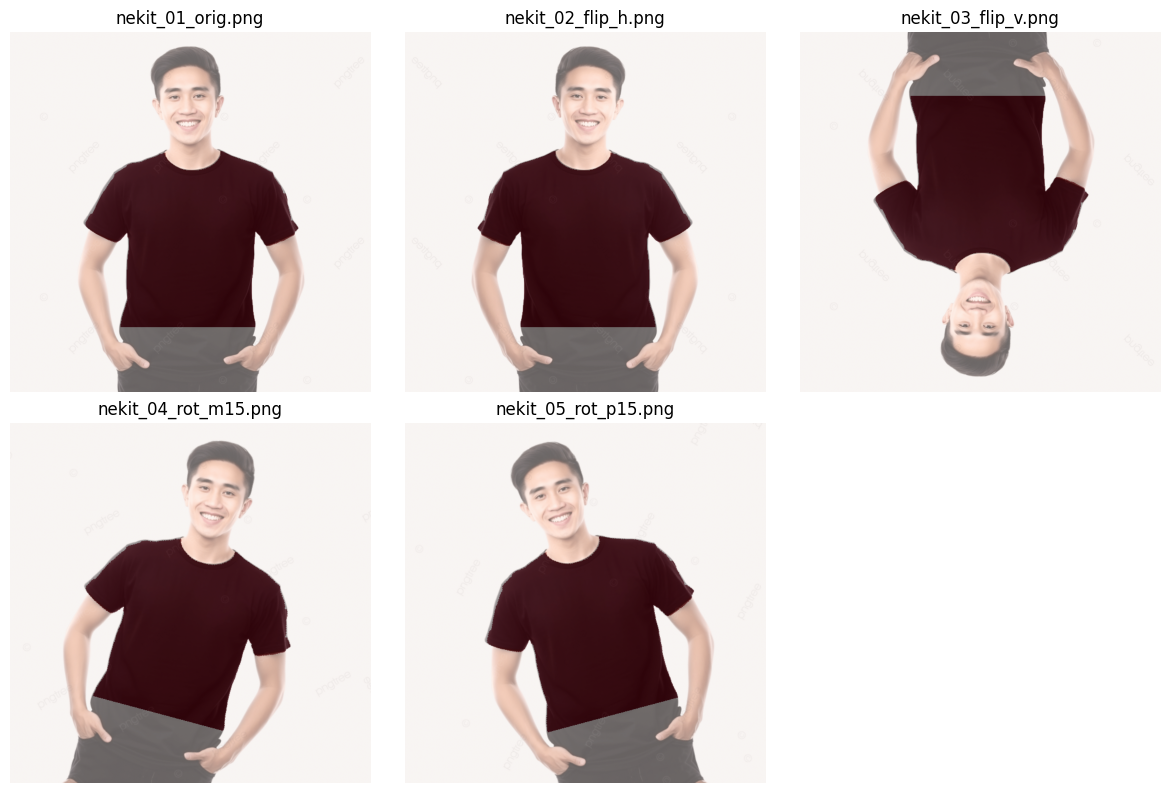

In [15]:
def show_samples(rows: int = 2, cols: int = 3):
    plt.figure(figsize=(cols * 4, rows * 4))
    for idx in range(rows * cols):
        if idx >= len(image_paths):
            break
        img = np.array(Image.open(image_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(mask_paths[idx]).convert('L')) > 127

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.imshow(mask, cmap='Reds', alpha=0.4)
        plt.axis('off')
        plt.title(image_paths[idx].name)
    plt.tight_layout()

show_samples()

## Подготовка наборов данных и загрузчиков

In [16]:
IMAGE_SIZE = 128
BATCH_SIZE = 2
VAL_RATIO = 0.3
SEED = 42

ids = [path.stem for path in image_paths]
rng = Random(SEED)
rng.shuffle(ids)
val_count = max(1, int(len(ids) * VAL_RATIO))
val_ids = set(ids[:val_count])
train_ids = [idx for idx in ids if idx not in val_ids]

print(f"Тренировочных примеров: {len(train_ids)}")
print(f"Валидационных примеров: {len(val_ids)}")

Тренировочных примеров: 4
Валидационных примеров: 1


In [17]:
class TShirtDataset(Dataset):
    def __init__(self, ids: List[str], augment: bool = False):
        self.ids = ids
        self.augment = augment

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sample_id = self.ids[idx]
        img_path = IMAGES_DIR / f"{sample_id}.png"
        mask_path = MASKS_DIR / f"{sample_id}.png"

        image = Image.open(img_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
        mask = Image.open(mask_path).convert('L').resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

        image = np.asarray(image, dtype=np.float32) / 255.0
        mask = (np.asarray(mask, dtype=np.float32) > 0.5).astype(np.float32)

        if self.augment:
            if np.random.rand() < 0.5:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()
            if np.random.rand() < 0.3:
                image = np.flipud(image).copy()
                mask = np.flipud(mask).copy()
            if np.random.rand() < 0.3:
                gamma = float(0.8 + 0.4 * np.random.rand())
                image = np.clip(image ** gamma, 0.0, 1.0)

        image = np.ascontiguousarray(image.transpose(2, 0, 1))
        mask = np.ascontiguousarray(mask)
        image_tensor = torch.from_numpy(image)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        return image_tensor, mask_tensor

train_dataset = TShirtDataset(train_ids, augment=True)
val_dataset = TShirtDataset(list(val_ids), augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"В train loader батчей: {len(train_loader)}")
print(f"В val loader батчей: {len(val_loader)}")


В train loader батчей: 2
В val loader батчей: 1


## Метрики качества

In [18]:
def segmentation_metrics(preds: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> Dict[str, float]:
    preds_prob = torch.sigmoid(preds)
    preds_bin = (preds_prob > threshold).float()

    targets = targets.float()

    tp = (preds_bin * targets).sum().item()
    fp = (preds_bin * (1.0 - targets)).sum().item()
    fn = ((1.0 - preds_bin) * targets).sum().item()
    tn = ((1.0 - preds_bin) * (1.0 - targets)).sum().item()

    eps = 1e-6
    accuracy = (tp + tn) / (tp + tn + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = tp / (tp + fp + fn + eps)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "iou": iou,
    }


def evaluate_model(model: nn.Module, loader: DataLoader, device: torch.device) -> Dict[str, float]:
    model.eval()
    aggregated = {k: 0.0 for k in ["accuracy", "precision", "recall", "f1", "iou"]}
    batches = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            logits = model(images)
            metrics = segmentation_metrics(logits, masks)
            for key, value in metrics.items():
                aggregated[key] += value
            batches += 1
    return {key: value / max(1, batches) for key, value in aggregated.items()}

## Полносвязная модель

In [ ]:
class FullyConnectedSegNet(nn.Module):
    def __init__(self, image_size: int):
        super().__init__()
        self.image_size = image_size
        flat_dim = 3 * image_size * image_size
        hidden = max(512, image_size * image_size // 2)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden // 2, image_size * image_size),
        )

    def forward(self, x):
        logits = self.net(x)
        return logits.view(-1, 1, self.image_size, self.image_size)


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    epochs: int = 40,
    lr: float = 1e-3,
    patience: int = 5,
    min_delta: float = 1e-4,
) -> list[dict]:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_state = None
    best_val = float('inf')
    history: list[dict] = []
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                logits = model(images)
                loss = criterion(logits, masks)
                val_loss += loss.item() * images.size(0)

        train_loss /= max(1, len(train_loader.dataset))
        val_loss /= max(1, len(val_loader.dataset))
        history.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

        improved = val_loss < best_val - min_delta
        if improved:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
        if patience > 0 and patience_counter >= patience:
            print(f"Ранний останов: epoch {epoch:03d}, нет улучшения на протяжении {patience} epoch")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {DEVICE}")

fc_model = FullyConnectedSegNet(IMAGE_SIZE).to(DEVICE)
fc_history = train_model(fc_model, train_loader, val_loader, DEVICE, epochs=40, lr=1e-3)
fc_metrics = evaluate_model(fc_model, val_loader, DEVICE)
print('Метрики полносвязной модели:', fc_metrics)


Используемое устройство: cuda
Epoch 001 | train_loss=1.3865 | val_loss=0.1784
Epoch 005 | train_loss=0.5924 | val_loss=0.4729
Ранний останов: epoch 006, нет улучшения на протяжении 5 epoch
Метрики полносвязной модели: {'accuracy': 0.9707641600969993, 'precision': 0.9081015716722789, 'recall': 0.9449512422318492, 'f1': 0.9261595122448085, 'iou': 0.8624748777311299}


## UNet

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetSmall(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_channels=32):
        super().__init__()
        self.down1 = DoubleConv(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base_channels * 4, base_channels * 8)

        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(base_channels * 8, base_channels * 4)
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(base_channels * 4, base_channels * 2)
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(base_channels * 2, base_channels)

        self.final = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool1(c1))
        c3 = self.down3(self.pool2(c2))

        bottleneck = self.bottleneck(self.pool3(c3))

        u3 = self.up3(bottleneck)
        u3 = torch.cat([u3, c3], dim=1)
        c3_up = self.conv3(u3)

        u2 = self.up2(c3_up)
        u2 = torch.cat([u2, c2], dim=1)
        c2_up = self.conv2(u2)

        u1 = self.up1(c2_up)
        u1 = torch.cat([u1, c1], dim=1)
        c1_up = self.conv1(u1)

        return self.final(c1_up)

unet_model = UNetSmall().to(DEVICE)
unet_history = train_model(unet_model, train_loader, val_loader, DEVICE, epochs=40, lr=1e-3)
unet_metrics = evaluate_model(unet_model, val_loader, DEVICE)
print('Метрики UNet:', unet_metrics)

Epoch 001 | train_loss=0.5931 | val_loss=0.6870
Epoch 005 | train_loss=0.3115 | val_loss=0.5182
Epoch 010 | train_loss=0.2448 | val_loss=0.4164
Epoch 015 | train_loss=0.2049 | val_loss=0.3745
Epoch 020 | train_loss=0.1724 | val_loss=0.2496
Epoch 025 | train_loss=0.1563 | val_loss=0.2058
Epoch 030 | train_loss=0.1294 | val_loss=0.1546
Epoch 035 | train_loss=0.1138 | val_loss=0.1287
Epoch 040 | train_loss=0.0991 | val_loss=0.1124
Метрики UNet: {'accuracy': 0.9916381835332252, 'precision': 0.9659926467628699, 'recall': 0.9918213271494742, 'f1': 0.9787361131623247, 'iou': 0.9583586623226874}


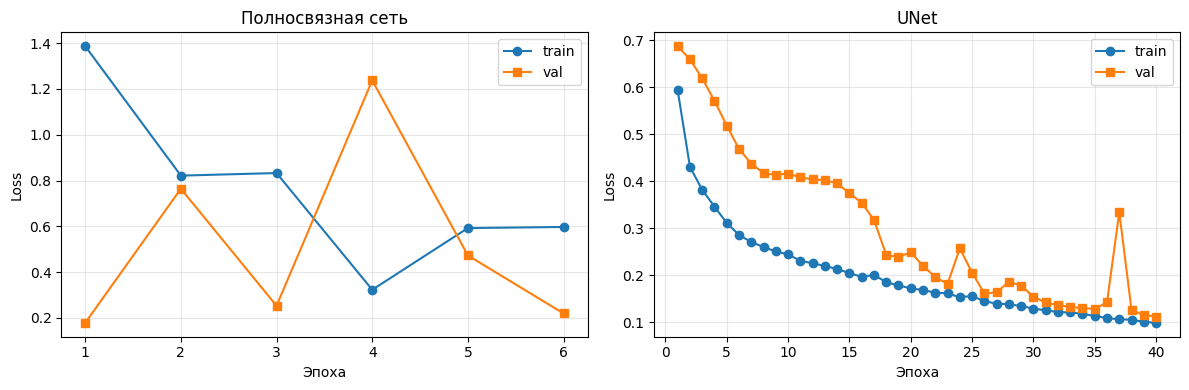

In [19]:
# Графики динамики функции потерь
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

for history, label, ax in [
    (fc_history, "Полносвязная сеть", axes[0]),
    (unet_history, "UNet", axes[1]),
]:
    epochs = [entry['epoch'] for entry in history]
    train_losses = [entry['train_loss'] for entry in history]
    val_losses = [entry['val_loss'] for entry in history]

    ax.plot(epochs, train_losses, label='train', marker='o')
    ax.plot(epochs, val_losses, label='val', marker='s')
    ax.set_title(label)
    ax.set_xlabel('Эпоха')
    ax.set_ylabel('Loss')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


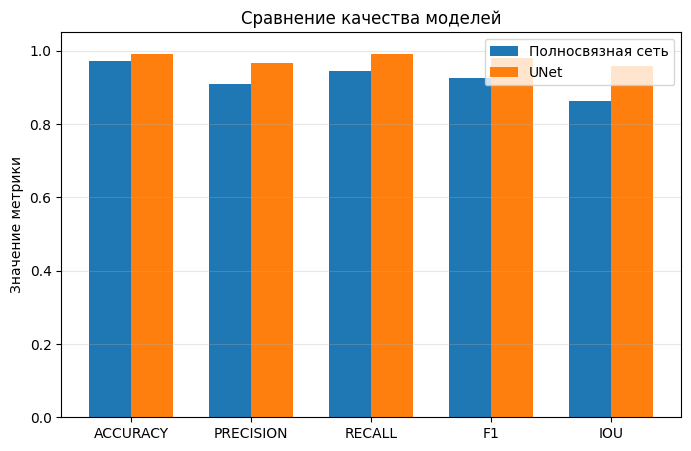

In [20]:
# Сравнение итоговых метрик
metrics_order = ['accuracy', 'precision', 'recall', 'f1', 'iou']
fc_values = [fc_metrics[m] for m in metrics_order]
unet_values = [unet_metrics[m] for m in metrics_order]

x = np.arange(len(metrics_order))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width / 2, fc_values, width, label='Полносвязная сеть')
plt.bar(x + width / 2, unet_values, width, label='UNet')
plt.xticks(x, [m.upper() for m in metrics_order])
plt.ylim(0, 1.05)
plt.ylabel('Значение метрики')
plt.title('Сравнение качества моделей')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()


## Визуализация предсказаний

Примеры предсказаний полносвязной модели:
Примеры предсказаний UNet:


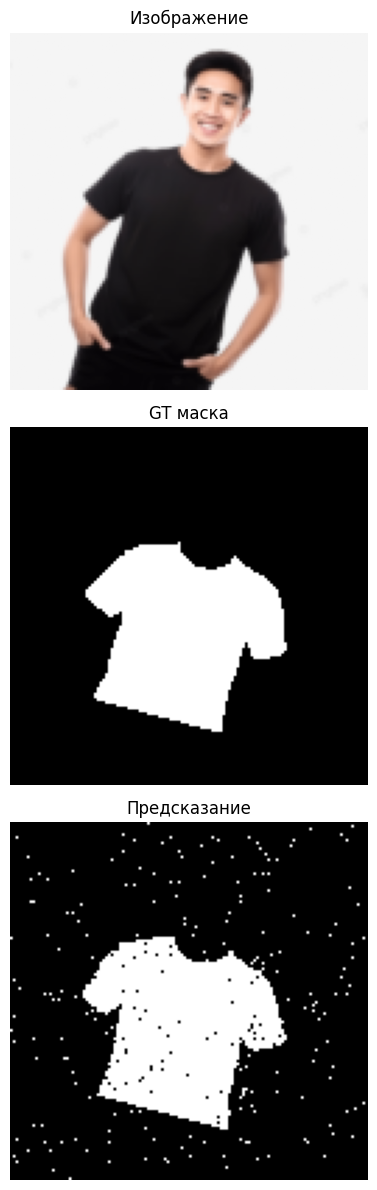

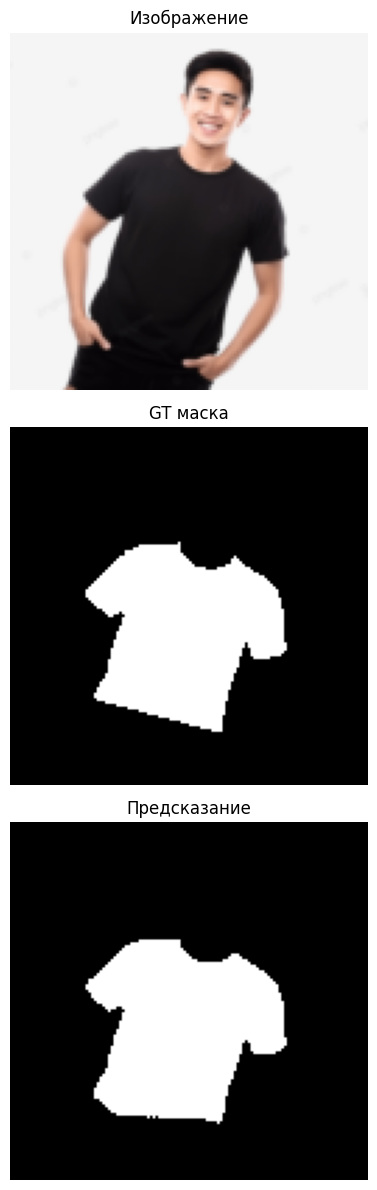

In [21]:
def plot_predictions(model: nn.Module, loader: DataLoader, device: torch.device, num_samples: int = 3):
    model.eval()
    shown = 0
    plt.figure(figsize=(4 * num_samples, 12))
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            for i in range(images.size(0)):
                if shown >= num_samples:
                    break
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                gt_np = masks[i].cpu().squeeze(0).numpy()
                pr_np = preds[i].cpu().squeeze(0).numpy()

                plt.subplot(3, num_samples, shown + 1)
                plt.imshow(img_np)
                plt.axis('off')
                if shown == 0:
                    plt.title('Изображение')

                plt.subplot(3, num_samples, num_samples + shown + 1)
                plt.imshow(gt_np, cmap='gray')
                plt.axis('off')
                if shown == 0:
                    plt.title('GT маска')

                plt.subplot(3, num_samples, 2 * num_samples + shown + 1)
                plt.imshow(pr_np, cmap='gray')
                plt.axis('off')
                if shown == 0:
                    plt.title('Предсказание')

                shown += 1
            if shown >= num_samples:
                break
    plt.tight_layout()

print('Примеры предсказаний полносвязной модели:')
plot_predictions(fc_model, val_loader, DEVICE, num_samples=3)

print('Примеры предсказаний UNet:')
plot_predictions(unet_model, val_loader, DEVICE, num_samples=3)

## Сравнение результатов

- Полносвязная сеть быстро сходится, но уже к шестой эпохе значение val_loss перестаёт улучшаться; итоговые метрики находятся в диапазоне 0.90–0.97.
- UNet продолжает снижать функцию потерь на протяжении всех эпох и достигает ощутимо более высоких значений по всем метрикам (F1 ≈ 0.98, IoU ≈ 0.96).
- По графикам видно, что сверточная архитектура гораздо стабильнее: кривые train/val-loss идут параллельно, без раннего переобучения, тогда как у полносвязной сети val_loss начинает расти.
- Разница особенно заметна при сравнении IoU и precision: UNet лучше восстанавливает форму футболки и аккуратнее работает по границам.

**Вывод:** даже на небольшом датасете UNet демонстрирует уверенное преимущество над полносвязной моделью, поэтому для задачи сегментации футболки её стоит использовать в качестве основного решения. Дополнительные улучшения можно получить за счёт расширения набора аугментаций и увеличения объёма исходных данных.
